In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm

import seaborn as sns; sns.set()

%matplotlib inline
import mpld3
mpld3.enable_notebook()
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.random.seed(10) # Reproduce results

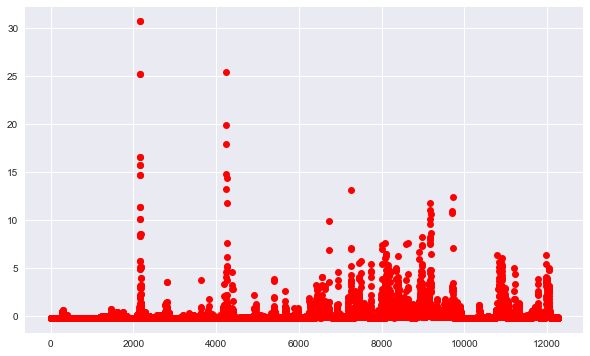

In [3]:
df = pd.read_pickle('data/1min_normalized.pkl')

plt.plot(df['so2'], 'ro')
plt.show()

df = df.reset_index()
df = df[pd.notnull(df).all(axis=1)]
df = df.reindex(np.random.permutation(df.index)) 

In [4]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df):
    return (np.array(df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, \
                         'h2s_ref', 'pressure', 'temperature', 'humidity', ]]),\
            np.array(df['so2']))

In [5]:
df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train)
X_valid, y_valid = dataframe_to_xy(df_valid)
X_test, y_test = dataframe_to_xy(df_test)

In [ ]:
init_grid_params = {
    'C': { 'min': 10e-3, 'max': 10e3 },
    'gamma': { 'min': 10e-5, 'max': 10e-1 }
}

data_train = (X_train, y_train)
data_valid = (X_valid, y_valid)

def SVR_through_grids(data_train, data_valid, grid_params, steps=2):
    X_train, y_train = data_train[0], data_train[1]
    X_valid, y_valid = data_valid[0], data_valid[1]
    while steps > 0:
        C_params, gamma_params = grid_params['C'], grid_params['gamma']
        C_grid = np.linspace(C_params['min'], C_params['max'], 10)
        gamma_grid = np.linspace(gamma_params['min'], gamma_params['max'], 10)

        scores = np.empty((len(C_grid), len(gamma_grid)))
        for i in range(len(C_grid)):
            for j in range(len(gamma_grid)):
                clf = svm.SVR(C=C_grid[i], gamma=gamma_grid[j], verbose=0)
                clf.fit(X_train, y_train)
                score = clf.score(X_valid, y_valid)
                scores[i, j] = score

        ax = sns.heatmap(scores, cmap="YlGnBu")
        plt.show()
                
        C_idx, gamma_idx = np.unravel_index(scores.argmax(), scores.shape) # Meilleur résultat en validation
        idx_min, idx_max  = C_idx - 2 if C_idx > 1 else 0, \
                            C_idx + 2 if C_idx < len(C_grid) - 2 else len(C_grid) - 1
        C_params['min'], C_params['max']  = C_grid[idx_min], C_grid[idx_max]
        idx_min, idx_max  = gamma_idx - 2 if gamma_idx > 1 else 0, \
                            gamma_idx + 2 if gamma_idx < len(gamma_grid) - 2 else len(gamma_grid) - 1
        gamma_params['min'], gamma_params['max']  = gamma_grid[idx_min], gamma_grid[idx_max]
        steps -= 1
    
    return C_grid[C_idx], gamma_grid[gamma_idx]
            

In [ ]:
C, gamma = SVR_through_grids(data_train, data_valid, init_grid_params)